# 0. Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [74]:
from sklearn.linear_model import LogisticRegression
from scipy import interp

In [4]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

In [5]:
from sklearn.metrics import average_precision_score

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

In [7]:
from sklearn.metrics import f1_score,make_scorer
scored=make_scorer(f1_score)

# 1. Data I/O

In [8]:
data=pd.read_csv('covtype.CSV',header=-1)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


# 2. Data Exploration

In [9]:
headers=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways'         
,'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Wilderness_Area_1','Wilderness_Area_2','Wilderness_Area_3','Wilderness_Area_4']

headers_init=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways'         
,'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Cover_Type']

soiltypes=[]
for i in range(1,41):
    soiltypes.append('Soil_Type_'+str(i))

soiltypes.append('Cover_Type')

for i in range(len(soiltypes)):
    headers.append(soiltypes[i])
    
data.columns=headers

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Wilderness_Area_1                     581012 non-null int64
Wilderness_Area_2                     581012 non-null int64
Wilderness_Area_3                     581012 non-null int64
Wilderness_Area_4                     581012 non-null int64
Soil_Type_1                           581012 non-

In [11]:
data['Cover_Type'].value_counts() # between class imbalance and within class imbalance

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

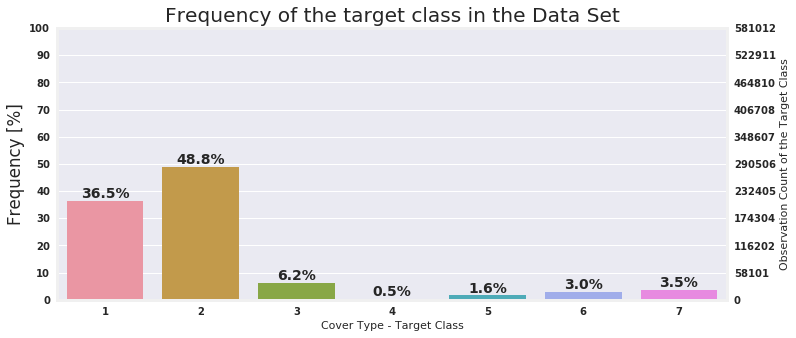

In [12]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,5))
ax=sns.countplot(x='Cover_Type', data=data);
plt.style.use('fivethirtyeight')
total=float(len(data))
plt.title('Frequency of the target class in the Data Set');
plt.ylabel('Observation Count of the Target Class');
plt.xlabel('Cover Type - Target Class');
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/total), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,total)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

# 3. Utility Functions

In [13]:
def get_features():
    return ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
    'Ele_minus_VDtHyd','Ele_plus_VDtHyd','Distanse_to_Hydrology','Hydro_plus_Fire','Hydro_minus_Fire','Hydro_plus_Road',
    'Hydro_minus_Road','Fire_plus_Road','Fire_minus_Road']

In [36]:
def get_features2():
    return ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']

In [14]:
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'16'}

In [248]:
import itertools

def plot_confusion_matrix(axd,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.sca(axd)
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1#print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=16)
    #plt.tight_layout()
    plt.ylabel('True label',**axis_font)
    plt.xlabel('Predicted label',**axis_font)
    plt.grid('off')

In [118]:
from sklearn.multiclass import OneVsRestClassifier

def model_fitting_and_post_processing(clf,X_train,Y_train,X_test,Y_test,clf_name='SVM',class_names=[0,1],cross_val=False):
    #average precision for the precision recall curves
    # passing dataframes into the function
    clf.fit(X_train.values,Y_train.values.ravel())
    #print(clf.best_estimator_)
    if cross_val:
        clf=clf.best_estimator_
        print('\n')
        print(clf)
        print('\n')
    predictions=clf.predict(X_test.values)
    #decision function
    try:
        Y_score = clf.decision_function(X_test.values)
    except:
        Y_score = clf.predict_proba(X_test.values)
        #pred_probab=model.predict_proba(X_test.values)

    Y_test_df=pd.get_dummies(Y_test,columns=['Cover_Type'])
    
    # printing the accuracy
    print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test.values,predictions))
    # predicting probabilities
    post_probab_predictions=clf.predict_proba(X_test.values)
    # assiging the probability
    post_probab_predictions=post_probab_predictions[:,1]
    # now subplotting
    #fig, axes=plt.subplots(3,1,figsize=(30,15))
    # Class Distribution
    plt.figure(figsize=(12,5))
    data_train=X_train.copy()
    data_train['Cover_Type']=Y_train.values
    #data_train['Class']=data_train['Class'].map({1.0:'Fraud',0.0:'Normal'})
    ax=sns.countplot(x='Cover_Type', data=data_train);
    total=float(len(data_train))
    plt.title('Frequency of the target class in the Training-set',**title_font)
    plt.ylabel('Frequency of the target',**axis_font)
    plt.xlabel('Target Class',**axis_font)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f} %'.format(height*100/total),ha="center")
    
    # Confusion Matrix
    cnf_matrix = confusion_matrix(Y_test.values,predictions)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(0,cnf_matrix, classes=class_names, title='Confusion matrix')
    #axes[1].grid('off')
    
    # ROC CURVE
    plot_roc(0,clf_name,Y_score,Y_test_df)
    # Precision-Recall Curve
    #plot_prc(axes[1,1],clf_name,Y_score,Y_test_df)


    #fig.tight_layout()
    print('\n')
    print('----------------------- Complete Classification Report -----------------------\n')
    print(classification_report(Y_test.values,predictions))
    print('\n')
    print('--------------------------- Post-processed Plots --------------------------\n')    
    return (predictions,post_probab_predictions)

In [242]:
def plot_roc(axd,clf_name,pred_probab,Y_test_df):
    #plt.sca(axd)


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(Y_test_df.iloc[:, i], pred_probab[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    roc_dict={}
    for j in range(len(roc_auc)):
        roc_dict[str('fpr')+str(j)]=fpr[j]
        roc_dict[str('tpr')+str(j)]=tpr[j]

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_df.values.ravel(), pred_probab.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    from itertools import cycle
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(7)]))
    lw=2
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(7):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    plt.style.use('ggplot')
    # Finally average it and compute AUC
    mean_tpr /= 7

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8,5))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='blue', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='green', linewidth=4)

    plt.plot([0, 1], [0, 1], 'r--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',**axis_font)
    plt.ylabel('True Positive Rate',**axis_font)
    titled='ROC '+clf_name + ' to multi-class'
    plt.title(titled,**title_font)
    plt.legend(loc="lower right")

In [17]:
def feature_engineering(data2,train_cons):
    data = data2
    data['Ele_minus_VDtHyd'] = data.Elevation-data.Vertical_Distance_To_Hydrology
    data['Ele_plus_VDtHyd'] = data.Elevation+data.Vertical_Distance_To_Hydrology
    data['Distanse_to_Hydrology'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5
    data['Hydro_plus_Fire'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Fire_Points']
    data['Hydro_minus_Fire'] = data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Fire_Points']    
    data['Hydro_plus_Road'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Roadways']
    data['Hydro_minus_Road'] = data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Roadways']
    data['Fire_plus_Road'] = data['Horizontal_Distance_To_Fire_Points']+data['Horizontal_Distance_To_Roadways']     
    data['Fire_minus_Road'] = data['Horizontal_Distance_To_Fire_Points']-data['Horizontal_Distance_To_Roadways']      
    return data

In [37]:
def data_prep(data, feat=False):
    
    train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data.Cover_Type)
    
    for col_name in soiltypes:
        if train[col_name].dtype=='int64':
            unique_cat=len(train[col_name].unique())
            #print("Feature:- {col_name} has {unique_cat} unique categories".format(col_name=col_name,unique_cat=unique_cat))
    
    #Remove Constant columns
    train_cons = []
    test_cons=[]
    for col in train.columns:
        if train[col].std() == 0:
            train_cons.append(col)
            test_cons.append(col)

    train=train.drop(train_cons,axis=1)
    test=test.drop(test_cons,axis=1)
    
    
    if feat:
        train_df = feature_engineering(train,train_cons)
        test_df = feature_engineering(test,train_cons)

        features_imp=get_features()
        for i in range(1,41):
            features_imp.append('Soil_Type_'+str(i))
        for j in range(1,5):
            features_imp.append('Wilderness_Area_'+str(j))

        X_train=train_df[features_imp]
        X_test=test_df[features_imp]


        Y_train=train_df[['Cover_Type']]
        Y_test=test_df[['Cover_Type']]
        
        Y_train=Y_train-1
        Y_test=Y_test-1


        features_num=get_features()

        X_train_num_Scld=StandardScaler().fit_transform(X_train[features_num])
        X_train.loc[:,:len(features_num)]=X_train_num_Scld

        X_test_num_Scld=StandardScaler().fit_transform(X_test[features_num])
        X_test.loc[:,:len(features_num)]=X_test_num_Scld

        
    else:
        
        X_train=train.drop('Cover_Type',axis=1)
        X_test=test.drop('Cover_Type',axis=1)
                
        Y_train=train[['Cover_Type']]
        Y_test=test[['Cover_Type']]
        
        Y_train=Y_train-1
        Y_test=Y_test-1


        features_num=get_features2()

        X_train_num_Scld=StandardScaler().fit_transform(X_train[features_num])
        X_train.loc[:,:len(features_num)]=X_train_num_Scld

        X_test_num_Scld=StandardScaler().fit_transform(X_test[features_num])
        X_test.loc[:,:len(features_num)]=X_test_num_Scld

    return(X_train,Y_train,X_test,Y_test)

In [127]:
def sample_prep(data):
    X_rtrain=data_resampled.drop(['Cover_Type'],axis=1)
    Y_rtrain=data_resampled[['Cover_Type']]
    xcols=X_rtrain.columns.tolist()
    X_rtrain=StandardScaler().fit_transform(X_rtrain)
    X_rtrain=pd.DataFrame(X_rtrain,columns=xcols)
    
    return (X_rtrain,Y_rtrain)

# 5. Model Building

In [198]:
import xgboost as xgb

In [199]:
X_train,Y_train,X_test,Y_test=data_prep(data,feat=True)
X_train_r, X_valid,Y_train_r,Y_valid = train_test_split(X_train,Y_train, test_size=0.1, random_state=0,stratify=Y_train.Cover_Type)
model=xgb.XGBClassifier(n_estimators=1500,learning_rate=0.1,max_depth=8,objective='multi:softprob',n_jobs=8,scale_pos_weight=1)

In [200]:
model.fit(X_train.values,Y_train.values.ravel(),eval_metric='mlogloss',eval_set=[(X_valid.values,Y_valid.values.ravel())],verbose=True,early_stopping_rounds=550)

[0]	validation_0-mlogloss:1.73531
Will train until validation_0-mlogloss hasn't improved in 550 rounds.
[1]	validation_0-mlogloss:1.57557
[2]	validation_0-mlogloss:1.44587
[3]	validation_0-mlogloss:1.33605
[4]	validation_0-mlogloss:1.24304
[5]	validation_0-mlogloss:1.16256
[6]	validation_0-mlogloss:1.09111
[7]	validation_0-mlogloss:1.02731
[8]	validation_0-mlogloss:0.971333
[9]	validation_0-mlogloss:0.921012
[10]	validation_0-mlogloss:0.876041
[11]	validation_0-mlogloss:0.83553
[12]	validation_0-mlogloss:0.798692
[13]	validation_0-mlogloss:0.765061
[14]	validation_0-mlogloss:0.73378
[15]	validation_0-mlogloss:0.706338
[16]	validation_0-mlogloss:0.680756
[17]	validation_0-mlogloss:0.657474
[18]	validation_0-mlogloss:0.635714
[19]	validation_0-mlogloss:0.615863
[20]	validation_0-mlogloss:0.597716
[21]	validation_0-mlogloss:0.58054
[22]	validation_0-mlogloss:0.565248
[23]	validation_0-mlogloss:0.551337
[24]	validation_0-mlogloss:0.538012
[25]	validation_0-mlogloss:0.526146
[26]	validation

[224]	validation_0-mlogloss:0.184863
[225]	validation_0-mlogloss:0.184477
[226]	validation_0-mlogloss:0.183585
[227]	validation_0-mlogloss:0.183369
[228]	validation_0-mlogloss:0.182647
[229]	validation_0-mlogloss:0.181817
[230]	validation_0-mlogloss:0.181388
[231]	validation_0-mlogloss:0.18088
[232]	validation_0-mlogloss:0.179682
[233]	validation_0-mlogloss:0.179072
[234]	validation_0-mlogloss:0.17842
[235]	validation_0-mlogloss:0.177739
[236]	validation_0-mlogloss:0.17684
[237]	validation_0-mlogloss:0.176105
[238]	validation_0-mlogloss:0.175497
[239]	validation_0-mlogloss:0.174173
[240]	validation_0-mlogloss:0.173362
[241]	validation_0-mlogloss:0.17287
[242]	validation_0-mlogloss:0.172387
[243]	validation_0-mlogloss:0.171955
[244]	validation_0-mlogloss:0.171543
[245]	validation_0-mlogloss:0.171202
[246]	validation_0-mlogloss:0.170576
[247]	validation_0-mlogloss:0.170132
[248]	validation_0-mlogloss:0.169852
[249]	validation_0-mlogloss:0.169587
[250]	validation_0-mlogloss:0.169171
[251]

[447]	validation_0-mlogloss:0.101612
[448]	validation_0-mlogloss:0.101393
[449]	validation_0-mlogloss:0.101319
[450]	validation_0-mlogloss:0.101197
[451]	validation_0-mlogloss:0.101111
[452]	validation_0-mlogloss:0.10093
[453]	validation_0-mlogloss:0.100817
[454]	validation_0-mlogloss:0.100499
[455]	validation_0-mlogloss:0.100327
[456]	validation_0-mlogloss:0.100228
[457]	validation_0-mlogloss:0.100062
[458]	validation_0-mlogloss:0.099719
[459]	validation_0-mlogloss:0.09955
[460]	validation_0-mlogloss:0.09943
[461]	validation_0-mlogloss:0.099377
[462]	validation_0-mlogloss:0.099231
[463]	validation_0-mlogloss:0.099058
[464]	validation_0-mlogloss:0.099016
[465]	validation_0-mlogloss:0.098842
[466]	validation_0-mlogloss:0.098374
[467]	validation_0-mlogloss:0.098265
[468]	validation_0-mlogloss:0.097937
[469]	validation_0-mlogloss:0.097798
[470]	validation_0-mlogloss:0.097582
[471]	validation_0-mlogloss:0.097367
[472]	validation_0-mlogloss:0.09728
[473]	validation_0-mlogloss:0.097043
[474]

[669]	validation_0-mlogloss:0.062874
[670]	validation_0-mlogloss:0.062839
[671]	validation_0-mlogloss:0.062658
[672]	validation_0-mlogloss:0.062485
[673]	validation_0-mlogloss:0.06244
[674]	validation_0-mlogloss:0.062331
[675]	validation_0-mlogloss:0.062199
[676]	validation_0-mlogloss:0.062085
[677]	validation_0-mlogloss:0.0618
[678]	validation_0-mlogloss:0.061667
[679]	validation_0-mlogloss:0.061574
[680]	validation_0-mlogloss:0.061416
[681]	validation_0-mlogloss:0.061355
[682]	validation_0-mlogloss:0.061306
[683]	validation_0-mlogloss:0.061239
[684]	validation_0-mlogloss:0.061188
[685]	validation_0-mlogloss:0.061127
[686]	validation_0-mlogloss:0.06099
[687]	validation_0-mlogloss:0.060944
[688]	validation_0-mlogloss:0.060887
[689]	validation_0-mlogloss:0.060783
[690]	validation_0-mlogloss:0.060723
[691]	validation_0-mlogloss:0.060685
[692]	validation_0-mlogloss:0.060624
[693]	validation_0-mlogloss:0.060553
[694]	validation_0-mlogloss:0.060428
[695]	validation_0-mlogloss:0.06028
[696]	

[892]	validation_0-mlogloss:0.042821
[893]	validation_0-mlogloss:0.042762
[894]	validation_0-mlogloss:0.042698
[895]	validation_0-mlogloss:0.042626
[896]	validation_0-mlogloss:0.042504
[897]	validation_0-mlogloss:0.042483
[898]	validation_0-mlogloss:0.042422
[899]	validation_0-mlogloss:0.042381
[900]	validation_0-mlogloss:0.042354
[901]	validation_0-mlogloss:0.042327
[902]	validation_0-mlogloss:0.042269
[903]	validation_0-mlogloss:0.042192
[904]	validation_0-mlogloss:0.042107
[905]	validation_0-mlogloss:0.042019
[906]	validation_0-mlogloss:0.041961
[907]	validation_0-mlogloss:0.041834
[908]	validation_0-mlogloss:0.041772
[909]	validation_0-mlogloss:0.041672
[910]	validation_0-mlogloss:0.041476
[911]	validation_0-mlogloss:0.041329
[912]	validation_0-mlogloss:0.041287
[913]	validation_0-mlogloss:0.041225
[914]	validation_0-mlogloss:0.041143
[915]	validation_0-mlogloss:0.041124
[916]	validation_0-mlogloss:0.041083
[917]	validation_0-mlogloss:0.041062
[918]	validation_0-mlogloss:0.041004
[

[1111]	validation_0-mlogloss:0.030164
[1112]	validation_0-mlogloss:0.030029
[1113]	validation_0-mlogloss:0.029968
[1114]	validation_0-mlogloss:0.02988
[1115]	validation_0-mlogloss:0.029863
[1116]	validation_0-mlogloss:0.029815
[1117]	validation_0-mlogloss:0.029718
[1118]	validation_0-mlogloss:0.029691
[1119]	validation_0-mlogloss:0.029615
[1120]	validation_0-mlogloss:0.029564
[1121]	validation_0-mlogloss:0.029541
[1122]	validation_0-mlogloss:0.029461
[1123]	validation_0-mlogloss:0.02942
[1124]	validation_0-mlogloss:0.029373
[1125]	validation_0-mlogloss:0.029327
[1126]	validation_0-mlogloss:0.029273
[1127]	validation_0-mlogloss:0.029201
[1128]	validation_0-mlogloss:0.029087
[1129]	validation_0-mlogloss:0.029076
[1130]	validation_0-mlogloss:0.028993
[1131]	validation_0-mlogloss:0.028962
[1132]	validation_0-mlogloss:0.02895
[1133]	validation_0-mlogloss:0.028903
[1134]	validation_0-mlogloss:0.02883
[1135]	validation_0-mlogloss:0.02876
[1136]	validation_0-mlogloss:0.028754
[1137]	validation

[1328]	validation_0-mlogloss:0.022493
[1329]	validation_0-mlogloss:0.022463
[1330]	validation_0-mlogloss:0.022434
[1331]	validation_0-mlogloss:0.02242
[1332]	validation_0-mlogloss:0.022395
[1333]	validation_0-mlogloss:0.022385
[1334]	validation_0-mlogloss:0.022367
[1335]	validation_0-mlogloss:0.022353
[1336]	validation_0-mlogloss:0.022346
[1337]	validation_0-mlogloss:0.022331
[1338]	validation_0-mlogloss:0.022306
[1339]	validation_0-mlogloss:0.02229
[1340]	validation_0-mlogloss:0.022262
[1341]	validation_0-mlogloss:0.022246
[1342]	validation_0-mlogloss:0.02224
[1343]	validation_0-mlogloss:0.022221
[1344]	validation_0-mlogloss:0.02221
[1345]	validation_0-mlogloss:0.022189
[1346]	validation_0-mlogloss:0.022176
[1347]	validation_0-mlogloss:0.022172
[1348]	validation_0-mlogloss:0.022151
[1349]	validation_0-mlogloss:0.022113
[1350]	validation_0-mlogloss:0.022107
[1351]	validation_0-mlogloss:0.022069
[1352]	validation_0-mlogloss:0.022057
[1353]	validation_0-mlogloss:0.022047
[1354]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [201]:
X_test.shape

(174304, 63)

In [202]:
pred=model.predict(X_test.values)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [203]:
from sklearn.metrics import accuracy_score
accuracy_score(pred,Y_test.values)

0.9731388837892417

In [212]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

x_cols=list(X_train.columns)
# Print the feature ranking
print("Feature ranking:")
cols={}
for f in range(52):
    cols[x_cols[indices[f]]]=importances[indices[f]]
    print("%d. feature %s : %f" % (f + 1, x_cols[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature Ele_minus_VDtHyd : 0.083914
2. feature Fire_minus_Road : 0.079303
3. feature Fire_plus_Road : 0.079068
4. feature Hydro_minus_Road : 0.061396
5. feature Hydro_plus_Fire : 0.058459
6. feature Elevation : 0.058405
7. feature Hydro_minus_Fire : 0.056976
8. feature Hydro_plus_Road : 0.051392
9. feature Horizontal_Distance_To_Fire_Points : 0.050180
10. feature Horizontal_Distance_To_Roadways : 0.045574
11. feature Aspect : 0.044656
12. feature Ele_plus_VDtHyd : 0.040579
13. feature Hillshade_Noon : 0.039001
14. feature Hillshade_9am : 0.038746
15. feature Hillshade_3pm : 0.036618
16. feature Distanse_to_Hydrology : 0.035648
17. feature Vertical_Distance_To_Hydrology : 0.035442
18. feature Slope : 0.025795
19. feature Horizontal_Distance_To_Hydrology : 0.019437
20. feature Wilderness_Area_3 : 0.005032
21. feature Wilderness_Area_1 : 0.004365
22. feature Soil_Type_29 : 0.003906
23. feature Soil_Type_10 : 0.003722
24. feature Soil_Type_33 : 0.003579
25. feature Soil

In [218]:
feat_imp_df=pd.DataFrame({'feature':list(cols.keys()),'importance':list(cols.values())}).sort_values('importance', ascending=False)

In [250]:
first20_feat=feat_imp_df[:20].feature

In [252]:
#first20_feat

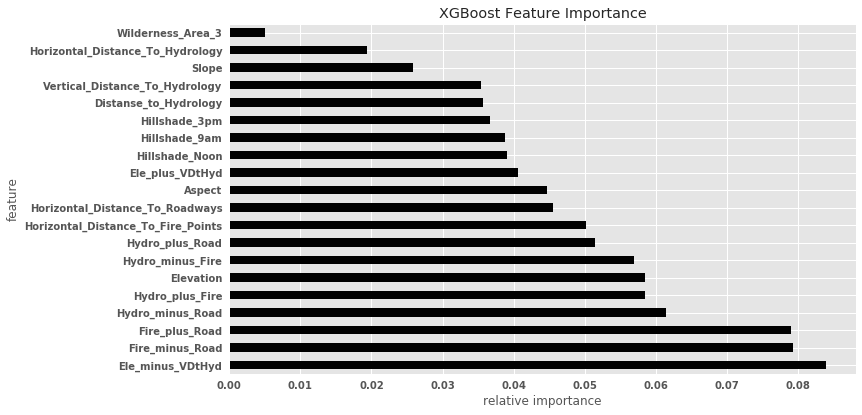

In [230]:
#plt.figure()
feat_df=feat_imp_df[:20]
feat_df.plot(kind='barh', x='feature', y='importance', legend=False, figsize=(10,6),color='black')
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

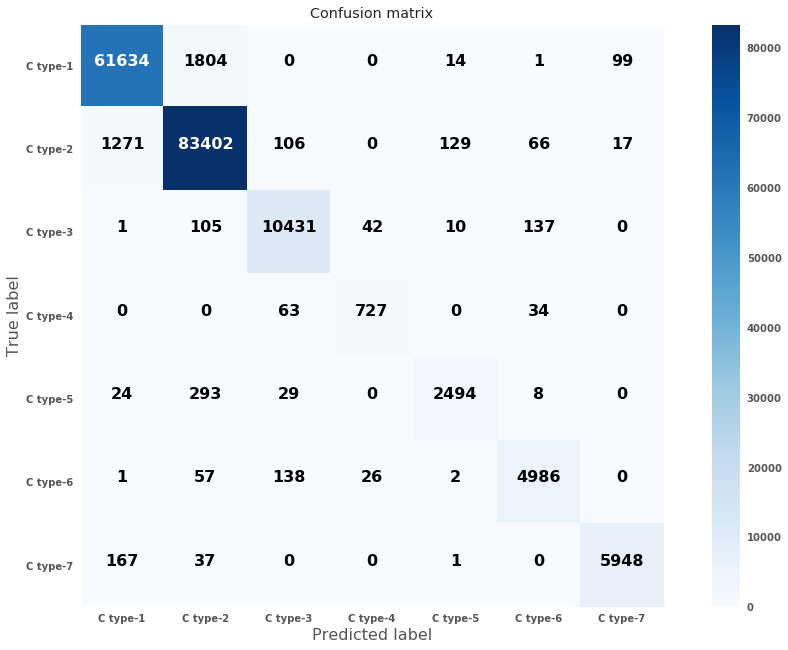

In [249]:
cnf_matrix = confusion_matrix(Y_test.values,pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
class_names = ['C type-1','C type-2','C type-3','C type-4','C type-5','C type-6','C type-7']
plt.figure(figsize=(15, 10))
plot_confusion_matrix(0,cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.grid('off')
plt.show()

In [234]:
print('------------------------Classification Report-------------------------------')
print(classification_report(pred,Y_test.values))

------------------------Classification Report-------------------------------
             precision    recall  f1-score   support

          0       0.97      0.98      0.97     63098
          1       0.98      0.97      0.98     85698
          2       0.97      0.97      0.97     10767
          3       0.88      0.91      0.90       795
          4       0.88      0.94      0.91      2650
          5       0.96      0.95      0.95      5232
          6       0.97      0.98      0.97      6064

avg / total       0.97      0.97      0.97    174304



In [246]:
pred_pr=model.predict_proba(X_test.values)
Y_test_df1=pd.get_dummies(Y_test,columns=['Cover_Type'])

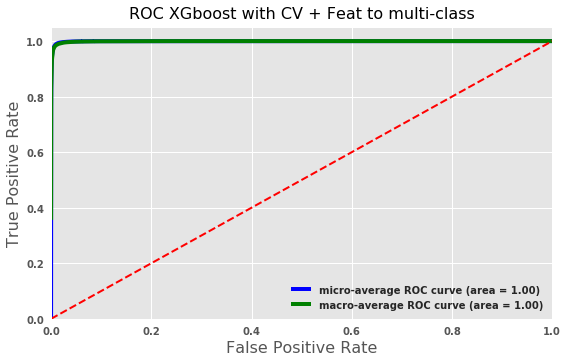

In [247]:
plot_roc(0,'XGboost with CV + Feat',pred_pr,Y_test_df1)

In [253]:
vis_test=X_test[first20_feat]
from sklearn.decomposition import PCA
vis_test=StandardScaler().fit_transform(vis_test)

In [255]:
pca=PCA(n_components=20,random_state=0)
vis_test_pca=pca.fit_transform(vis_test)

In [272]:
test_pca=vis_test[:,:2]

In [274]:
test_pca=pd.DataFrame(test_pca,columns=['PCA-1','PCA-2'])
test_pca['Cover_Type']=Y_test['Cover_Type']

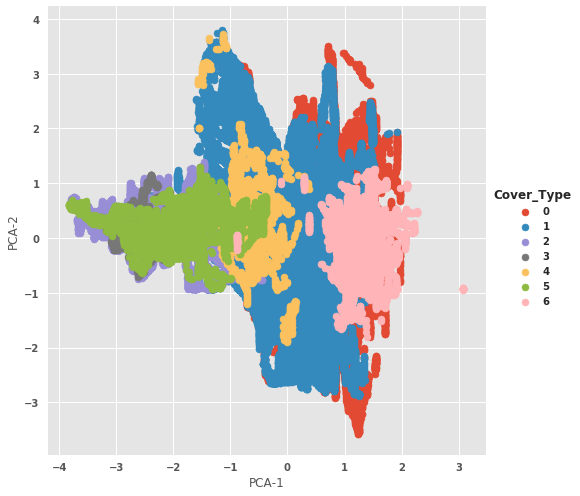

In [275]:
sns.FacetGrid(test_pca, hue="Cover_Type", size=7).map(plt.scatter, "PCA-1", "PCA-2").add_legend()

In [257]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,random_state=0,verbose=10)

In [258]:
vis_test_tsne=tsne.fit_transform(vis_test_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 174304 samples in 0.266s...
[t-SNE] Computed neighbors for 174304 samples in 555.966s...
[t-SNE] Computed conditional probabilities for sample 1000 / 174304
[t-SNE] Computed conditional probabilities for sample 2000 / 174304
[t-SNE] Computed conditional probabilities for sample 3000 / 174304
[t-SNE] Computed conditional probabilities for sample 4000 / 174304
[t-SNE] Computed conditional probabilities for sample 5000 / 174304
[t-SNE] Computed conditional probabilities for sample 6000 / 174304
[t-SNE] Computed conditional probabilities for sample 7000 / 174304
[t-SNE] Computed conditional probabilities for sample 8000 / 174304
[t-SNE] Computed conditional probabilities for sample 9000 / 174304
[t-SNE] Computed conditional probabilities for sample 10000 / 174304
[t-SNE] Computed conditional probabilities for sample 11000 / 174304
[t-SNE] Computed conditional probabilities for sample 12000 / 174304
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 118000 / 174304
[t-SNE] Computed conditional probabilities for sample 119000 / 174304
[t-SNE] Computed conditional probabilities for sample 120000 / 174304
[t-SNE] Computed conditional probabilities for sample 121000 / 174304
[t-SNE] Computed conditional probabilities for sample 122000 / 174304
[t-SNE] Computed conditional probabilities for sample 123000 / 174304
[t-SNE] Computed conditional probabilities for sample 124000 / 174304
[t-SNE] Computed conditional probabilities for sample 125000 / 174304
[t-SNE] Computed conditional probabilities for sample 126000 / 174304
[t-SNE] Computed conditional probabilities for sample 127000 / 174304
[t-SNE] Computed conditional probabilities for sample 128000 / 174304
[t-SNE] Computed conditional probabilities for sample 129000 / 174304
[t-SNE] Computed conditional probabilities for sample 130000 / 174304
[t-SNE] Computed conditional probabilities for sample 131000 / 174304
[t-SNE] Computed con

In [262]:
test_viz=vis_test_tsne

In [263]:
test_vis=pd.DataFrame(test_viz,columns=['t-SNE-1','t-SNE-2'])

In [268]:
Y_test.reset_index(inplace=True)
Y_test.drop('index',axis=1,inplace=True)
test_vis['Cover_Type']=Y_test['Cover_Type']

In [279]:
test_temp=test_vis[:10000]

In [280]:
test_temp.head()

,t-SNE-1,t-SNE-2,Cover_Type
0,1.194292,43.012520,3
1,4.024992,38.176018,2
2,-10.649167,32.706490,1
3,9.929911,28.134077,1
4,-7.963741,-39.387501,6


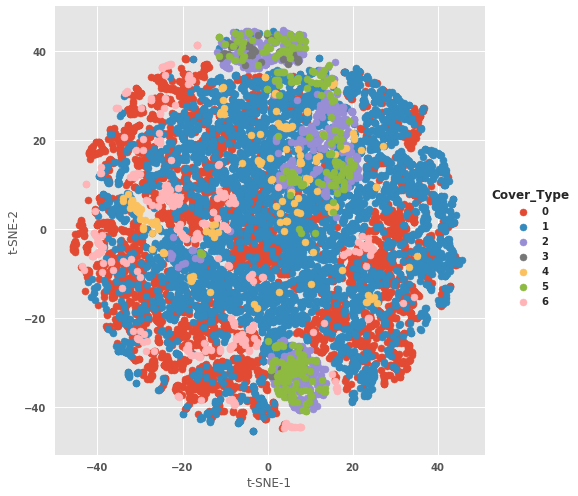

In [281]:
sns.FacetGrid(test_temp, hue="Cover_Type", size=7).map(plt.scatter, "t-SNE-1", "t-SNE-2").add_legend()

In [283]:
X_train,Y_train,X_test,Y_test=data_prep(data,feat=True)

In [284]:
X_test['Cover_Type']=Y_test['Cover_Type']

In [ ]:
data_t=data.iloc[:17000]

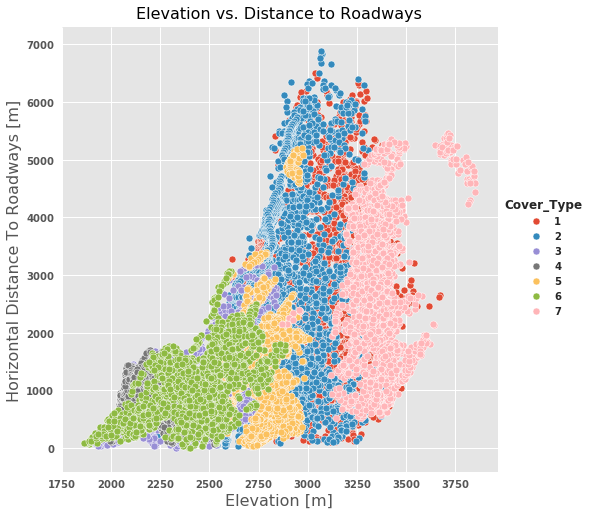

In [297]:
plt.style.use('ggplot')
sns.pairplot(data_t, hue="Cover_Type", size=7, x_vars="Elevation",y_vars="Horizontal_Distance_To_Roadways" )
plt.title('Elevation vs. Distance to Roadways',**title_font)

plt.xlabel('Elevation [m]',**axis_font)
plt.ylabel('Horizontal Distance To Roadways [m]',**axis_font)

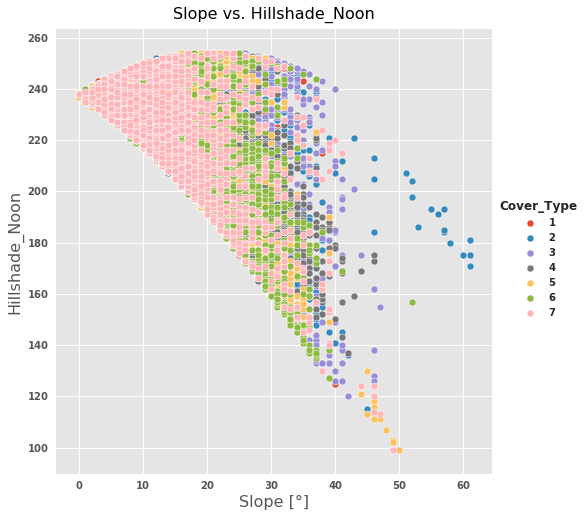

In [298]:
plt.style.use('ggplot')
sns.pairplot(data_t, hue="Cover_Type", size=7, x_vars="Slope",y_vars="Hillshade_Noon" )
plt.title('Slope vs. Hillshade_Noon',**title_font)

plt.xlabel('Slope [°]',**axis_font)
plt.ylabel('Hillshade_Noon',**axis_font)

In [302]:
data_t=X_test.iloc[:17000]

In [308]:
data=data_t.iloc[:,:10]

In [311]:
#sns.pairplot(data_t["Slope"],size=7)
#plt.title('Feature Slope distribution',**title_font)
#plt.xlabel('Slope [°]',**axis_font)
#plt.ylabel('Hillshade_Noon',**axis_font)

## 5.1 Logistic Regression Benchmark

The accruacy of Logisitic Reg. on the Test set:  0.7148545070681109


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.71      0.69      0.70     63552
          1       0.74      0.80      0.77     84991
          2       0.62      0.85      0.71     10726
          3       0.65      0.27      0.38       824
          4       0.26      0.01      0.02      2848
          5       0.43      0.09      0.15      5210
          6       0.71      0.53      0.61      6153

avg / total       0.70      0.71      0.70    174304



--------------------------- Post-processed Plots --------------------------



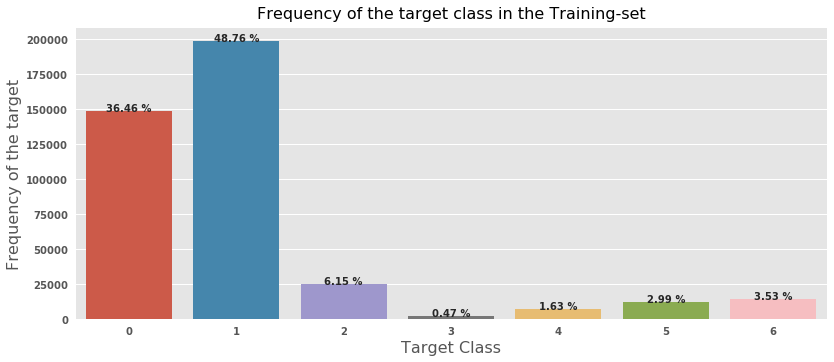

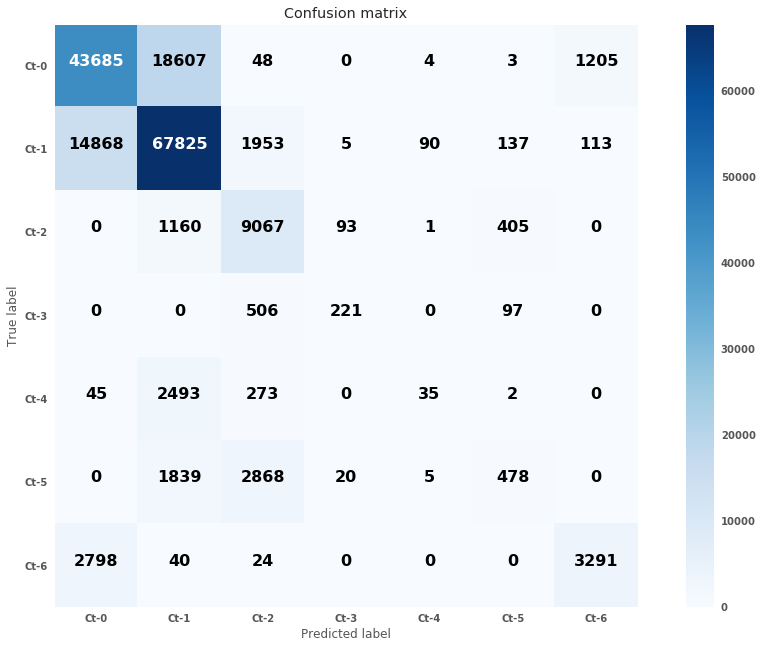

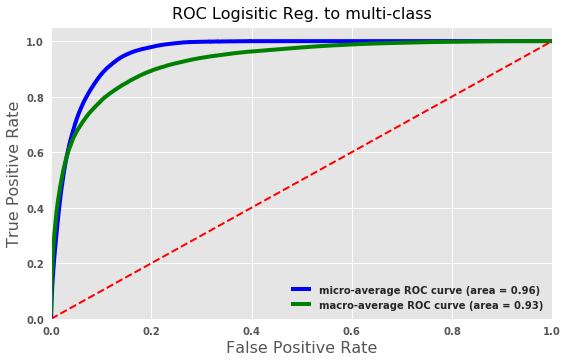

In [119]:
X_train,Y_train,X_test,Y_test=data_prep(data)
clf_log=LogisticRegression(random_state=0,multi_class='ovr',n_jobs=8)
pred_lg,probab_lg=model_fitting_and_post_processing(clf_log,X_train,Y_train,X_test,Y_test,clf_name='Logisitic Reg.',class_names=['Ct-0','Ct-1','Ct-2','Ct-3','Ct-4','Ct-5','Ct-6'])

In [124]:
#X_train.info()

The accruacy of Logisitic Reg. on the Test set:  0.7147627134202313


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.71      0.69      0.70     63552
          1       0.74      0.80      0.77     84991
          2       0.62      0.84      0.71     10726
          3       0.65      0.27      0.38       824
          4       0.27      0.01      0.03      2848
          5       0.43      0.10      0.16      5210
          6       0.71      0.53      0.61      6153

avg / total       0.70      0.71      0.70    174304



--------------------------- Post-processed Plots --------------------------



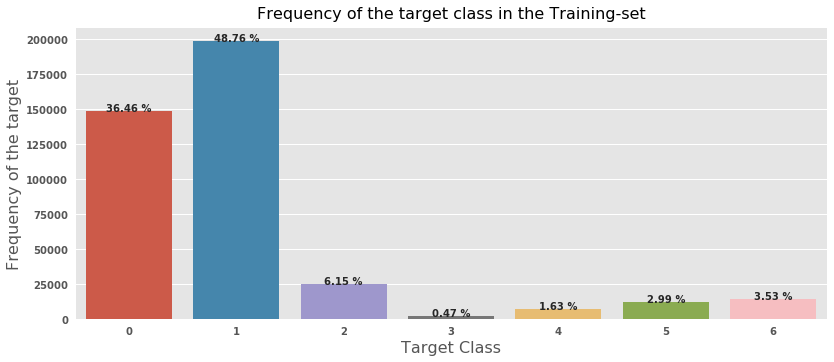

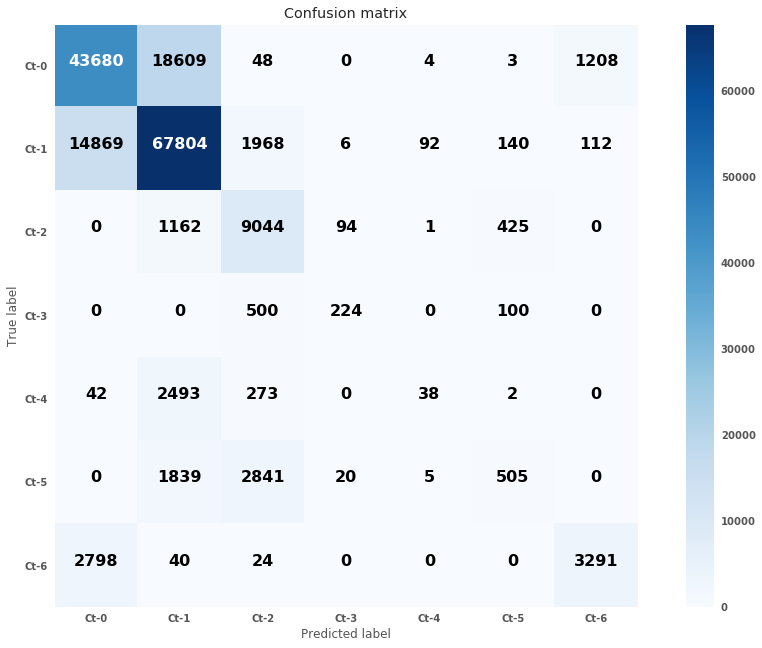

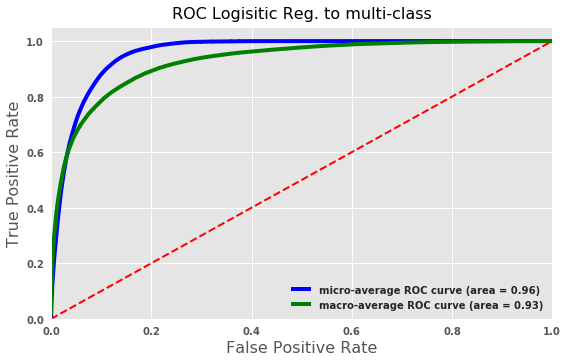

In [120]:
X_train,Y_train,X_test,Y_test=data_prep(data,feat=True)
clf_log2=LogisticRegression(random_state=0,multi_class='ovr',n_jobs=8)
pred_lg2,probab_lg2=model_fitting_and_post_processing(clf_log2,X_train,Y_train,X_test,Y_test,clf_name='Logisitic Reg + CV',class_names=['Ct-0','Ct-1','Ct-2','Ct-3','Ct-4','Ct-5','Ct-6'])

In [128]:
X_train,Y_train,X_test,Y_test=data_prep(data,feat=True)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
xcols=X_train.columns.tolist()
X_undersampled,Y_undersampled=rus.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_undersampled,columns=xcols)
data_resampled['Cover_Type']=Y_undersampled
X_utrain,Y_utrain=sample_prep(data_resampled)

The accruacy of Logisitic Reg + CV + Undersampling on the Test set:  0.43964567651918485


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.70      0.31      0.43     63552
          1       0.76      0.51      0.61     84991
          2       0.48      0.18      0.26     10726
          3       0.15      0.95      0.26       824
          4       0.07      0.68      0.13      2848
          5       0.19      0.57      0.28      5210
          6       0.16      0.98      0.27      6153

avg / total       0.67      0.44      0.49    174304



--------------------------- Post-processed Plots --------------------------



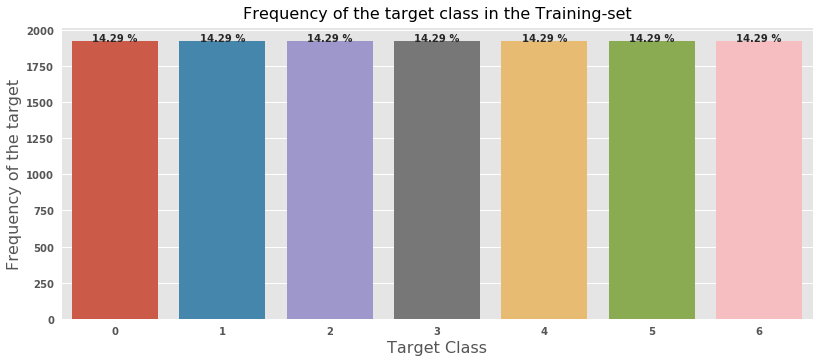

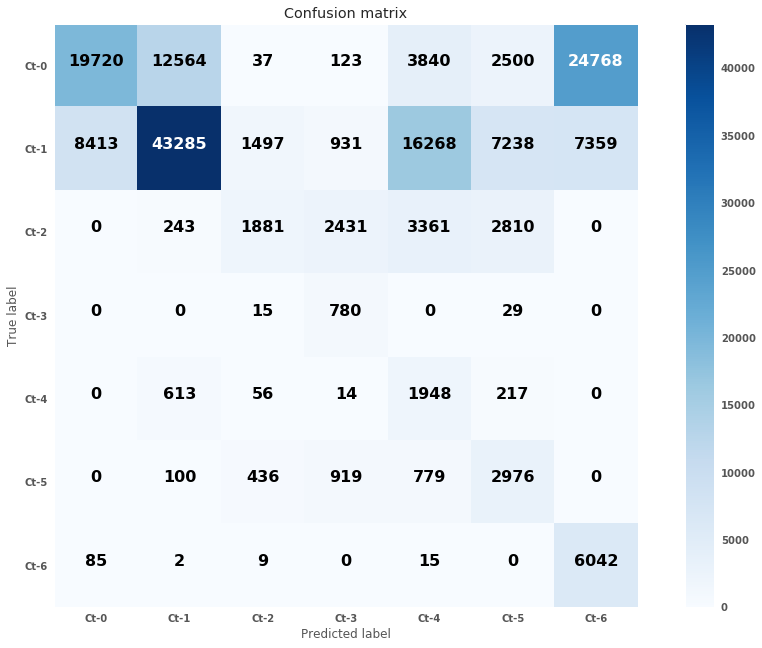

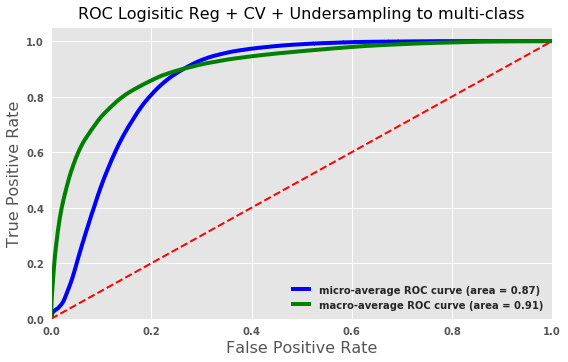

In [130]:
clf_log3=LogisticRegression(random_state=0,multi_class='ovr',n_jobs=8)
pred_lg3,probab_lg3=model_fitting_and_post_processing(clf_log3,X_utrain,Y_utrain,X_test,Y_test,clf_name='Logisitic Reg + CV + Undersampling',class_names=['Ct-0','Ct-1','Ct-2','Ct-3','Ct-4','Ct-5','Ct-6'])

## 5.2 XGBoost+ NO CV

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost on the Test set:  0.816951991922159


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.82      0.78      0.80     63552
          1       0.81      0.88      0.84     84991
          2       0.80      0.88      0.84     10726
          3       0.88      0.80      0.84       824
          4       0.87      0.31      0.46      2848
          5       0.81      0.47      0.60      5210
          6       0.92      0.79      0.85      6153

avg / total       0.82      0.82      0.81    174304



--------------------------- Post-processed Plots --------------------------



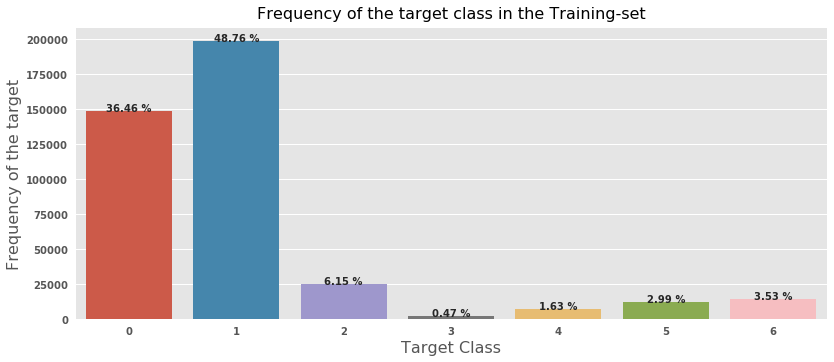

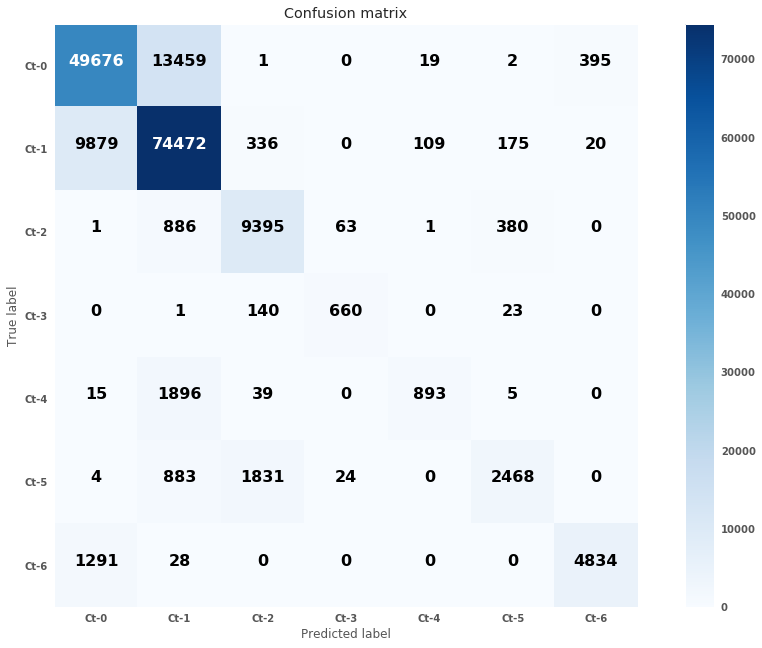

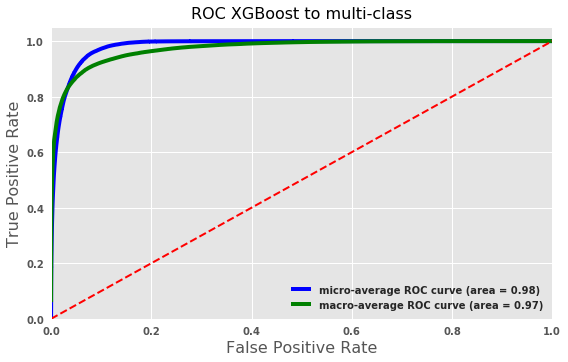

In [131]:
X_train,Y_train,X_test,Y_test=data_prep(data)
model_xgb=xgb.XGBClassifier(n_estimators=200,learning_rate=0.01,max_depth=8,objective='multi:softprob',n_jobs=8,scale_pos_weight=1)
pred_xg1,probab_xg1=model_fitting_and_post_processing(model_xgb,X_train,Y_train,X_test,Y_test,clf_name='XGBoost',class_names=['Ct-0','Ct-1','Ct-2','Ct-3','Ct-4','Ct-5','Ct-6'])

In [145]:
X_train,Y_train,X_test,Y_test=data_prep(data,feat=True)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
xcols=X_train.columns.tolist()
X_undersampled,Y_undersampled=rus.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_undersampled,columns=xcols)
data_resampled['Cover_Type']=Y_undersampled
X_utrain,Y_utrain=sample_prep(data_resampled)

X_train_r, X_valid,Y_train_r,Y_valid = train_test_split(X_utrain,Y_utrain, test_size=0.1, random_state=0,stratify=Y_utrain.Cover_Type)
model=xgb.XGBClassifier(n_estimators=1500,learning_rate=0.01,max_depth=8,objective='multi:softprob',n_jobs=8,scale_pos_weight=1)

In [146]:
model.fit(X_train_r.values,Y_train_r.values.ravel(),eval_metric='mlogloss',eval_set=[(X_valid.values,Y_valid.values.ravel())],verbose=True,early_stopping_rounds=550)

[0]	validation_0-mlogloss:1.92532
Will train until validation_0-mlogloss hasn't improved in 550 rounds.
[1]	validation_0-mlogloss:1.90534
[2]	validation_0-mlogloss:1.88592
[3]	validation_0-mlogloss:1.8669
[4]	validation_0-mlogloss:1.84832
[5]	validation_0-mlogloss:1.83033
[6]	validation_0-mlogloss:1.81259
[7]	validation_0-mlogloss:1.79527
[8]	validation_0-mlogloss:1.77842
[9]	validation_0-mlogloss:1.76175
[10]	validation_0-mlogloss:1.74568
[11]	validation_0-mlogloss:1.72973
[12]	validation_0-mlogloss:1.71403
[13]	validation_0-mlogloss:1.69872
[14]	validation_0-mlogloss:1.6837
[15]	validation_0-mlogloss:1.66898
[16]	validation_0-mlogloss:1.65452
[17]	validation_0-mlogloss:1.64019
[18]	validation_0-mlogloss:1.62626
[19]	validation_0-mlogloss:1.6124
[20]	validation_0-mlogloss:1.59876
[21]	validation_0-mlogloss:1.58555
[22]	validation_0-mlogloss:1.57256
[23]	validation_0-mlogloss:1.55959
[24]	validation_0-mlogloss:1.54697
[25]	validation_0-mlogloss:1.53472
[26]	validation_0-mlogloss:1.5223

[226]	validation_0-mlogloss:0.641588
[227]	validation_0-mlogloss:0.640125
[228]	validation_0-mlogloss:0.63873
[229]	validation_0-mlogloss:0.637333
[230]	validation_0-mlogloss:0.635907
[231]	validation_0-mlogloss:0.634525
[232]	validation_0-mlogloss:0.633117
[233]	validation_0-mlogloss:0.631801
[234]	validation_0-mlogloss:0.630437
[235]	validation_0-mlogloss:0.629097
[236]	validation_0-mlogloss:0.627776
[237]	validation_0-mlogloss:0.626411
[238]	validation_0-mlogloss:0.625044
[239]	validation_0-mlogloss:0.623756
[240]	validation_0-mlogloss:0.622405
[241]	validation_0-mlogloss:0.621183
[242]	validation_0-mlogloss:0.619891
[243]	validation_0-mlogloss:0.618623
[244]	validation_0-mlogloss:0.617405
[245]	validation_0-mlogloss:0.616075
[246]	validation_0-mlogloss:0.614862
[247]	validation_0-mlogloss:0.613651
[248]	validation_0-mlogloss:0.612482
[249]	validation_0-mlogloss:0.611263
[250]	validation_0-mlogloss:0.610032
[251]	validation_0-mlogloss:0.608833
[252]	validation_0-mlogloss:0.607631
[2

[449]	validation_0-mlogloss:0.469682
[450]	validation_0-mlogloss:0.469327
[451]	validation_0-mlogloss:0.468927
[452]	validation_0-mlogloss:0.468489
[453]	validation_0-mlogloss:0.468109
[454]	validation_0-mlogloss:0.467733
[455]	validation_0-mlogloss:0.467337
[456]	validation_0-mlogloss:0.466946
[457]	validation_0-mlogloss:0.466636
[458]	validation_0-mlogloss:0.46625
[459]	validation_0-mlogloss:0.465911
[460]	validation_0-mlogloss:0.465552
[461]	validation_0-mlogloss:0.465222
[462]	validation_0-mlogloss:0.464853
[463]	validation_0-mlogloss:0.464512
[464]	validation_0-mlogloss:0.464156
[465]	validation_0-mlogloss:0.463824
[466]	validation_0-mlogloss:0.463476
[467]	validation_0-mlogloss:0.463127
[468]	validation_0-mlogloss:0.462793
[469]	validation_0-mlogloss:0.46249
[470]	validation_0-mlogloss:0.462188
[471]	validation_0-mlogloss:0.461892
[472]	validation_0-mlogloss:0.461616
[473]	validation_0-mlogloss:0.461296
[474]	validation_0-mlogloss:0.460986
[475]	validation_0-mlogloss:0.460615
[47

[672]	validation_0-mlogloss:0.415124
[673]	validation_0-mlogloss:0.414965
[674]	validation_0-mlogloss:0.414807
[675]	validation_0-mlogloss:0.414675
[676]	validation_0-mlogloss:0.414515
[677]	validation_0-mlogloss:0.414345
[678]	validation_0-mlogloss:0.414192
[679]	validation_0-mlogloss:0.414039
[680]	validation_0-mlogloss:0.413843
[681]	validation_0-mlogloss:0.413732
[682]	validation_0-mlogloss:0.413548
[683]	validation_0-mlogloss:0.413396
[684]	validation_0-mlogloss:0.413222
[685]	validation_0-mlogloss:0.413071
[686]	validation_0-mlogloss:0.412908
[687]	validation_0-mlogloss:0.412747
[688]	validation_0-mlogloss:0.412598
[689]	validation_0-mlogloss:0.412454
[690]	validation_0-mlogloss:0.412303
[691]	validation_0-mlogloss:0.412151
[692]	validation_0-mlogloss:0.412053
[693]	validation_0-mlogloss:0.41194
[694]	validation_0-mlogloss:0.411806
[695]	validation_0-mlogloss:0.411689
[696]	validation_0-mlogloss:0.411567
[697]	validation_0-mlogloss:0.41148
[698]	validation_0-mlogloss:0.411333
[69

[895]	validation_0-mlogloss:0.392494
[896]	validation_0-mlogloss:0.392442
[897]	validation_0-mlogloss:0.392388
[898]	validation_0-mlogloss:0.392263
[899]	validation_0-mlogloss:0.392198
[900]	validation_0-mlogloss:0.392159
[901]	validation_0-mlogloss:0.391987
[902]	validation_0-mlogloss:0.391973
[903]	validation_0-mlogloss:0.391899
[904]	validation_0-mlogloss:0.391812
[905]	validation_0-mlogloss:0.391715
[906]	validation_0-mlogloss:0.391659
[907]	validation_0-mlogloss:0.391557
[908]	validation_0-mlogloss:0.391507
[909]	validation_0-mlogloss:0.391419
[910]	validation_0-mlogloss:0.391414
[911]	validation_0-mlogloss:0.391327
[912]	validation_0-mlogloss:0.391297
[913]	validation_0-mlogloss:0.39124
[914]	validation_0-mlogloss:0.391136
[915]	validation_0-mlogloss:0.391099
[916]	validation_0-mlogloss:0.391064
[917]	validation_0-mlogloss:0.391033
[918]	validation_0-mlogloss:0.39095
[919]	validation_0-mlogloss:0.390884
[920]	validation_0-mlogloss:0.390801
[921]	validation_0-mlogloss:0.390716
[92

[1114]	validation_0-mlogloss:0.37947
[1115]	validation_0-mlogloss:0.379429
[1116]	validation_0-mlogloss:0.379392
[1117]	validation_0-mlogloss:0.379364
[1118]	validation_0-mlogloss:0.379334
[1119]	validation_0-mlogloss:0.379285
[1120]	validation_0-mlogloss:0.37925
[1121]	validation_0-mlogloss:0.379206
[1122]	validation_0-mlogloss:0.379199
[1123]	validation_0-mlogloss:0.379168
[1124]	validation_0-mlogloss:0.379116
[1125]	validation_0-mlogloss:0.379101
[1126]	validation_0-mlogloss:0.379058
[1127]	validation_0-mlogloss:0.378998
[1128]	validation_0-mlogloss:0.378954
[1129]	validation_0-mlogloss:0.378886
[1130]	validation_0-mlogloss:0.378816
[1131]	validation_0-mlogloss:0.378804
[1132]	validation_0-mlogloss:0.378754
[1133]	validation_0-mlogloss:0.378718
[1134]	validation_0-mlogloss:0.378644
[1135]	validation_0-mlogloss:0.378552
[1136]	validation_0-mlogloss:0.378502
[1137]	validation_0-mlogloss:0.378477
[1138]	validation_0-mlogloss:0.37845
[1139]	validation_0-mlogloss:0.378363
[1140]	validati

[1331]	validation_0-mlogloss:0.370775
[1332]	validation_0-mlogloss:0.370747
[1333]	validation_0-mlogloss:0.370704
[1334]	validation_0-mlogloss:0.37066
[1335]	validation_0-mlogloss:0.37065
[1336]	validation_0-mlogloss:0.370608
[1337]	validation_0-mlogloss:0.370564
[1338]	validation_0-mlogloss:0.370538
[1339]	validation_0-mlogloss:0.370526
[1340]	validation_0-mlogloss:0.370499
[1341]	validation_0-mlogloss:0.370478
[1342]	validation_0-mlogloss:0.370451
[1343]	validation_0-mlogloss:0.37037
[1344]	validation_0-mlogloss:0.370341
[1345]	validation_0-mlogloss:0.370318
[1346]	validation_0-mlogloss:0.370274
[1347]	validation_0-mlogloss:0.370248
[1348]	validation_0-mlogloss:0.370196
[1349]	validation_0-mlogloss:0.370199
[1350]	validation_0-mlogloss:0.370144
[1351]	validation_0-mlogloss:0.370087
[1352]	validation_0-mlogloss:0.370002
[1353]	validation_0-mlogloss:0.369946
[1354]	validation_0-mlogloss:0.369941
[1355]	validation_0-mlogloss:0.369914
[1356]	validation_0-mlogloss:0.369865
[1357]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [147]:
pred=model.predict(X_test.values)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [148]:
pred_probab=model.predict_proba(X_test.values)

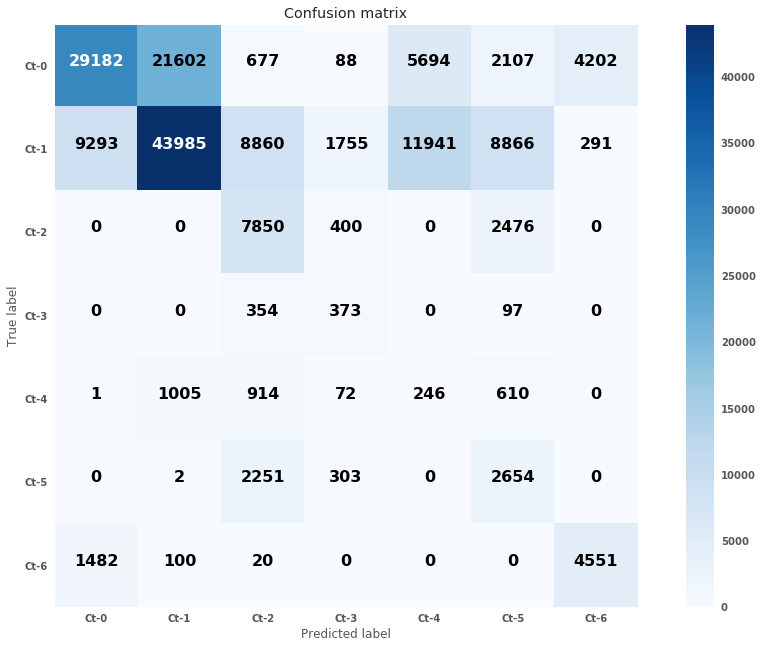

In [149]:
cnf_matrix = confusion_matrix(Y_test.values,pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
class_names = ['Ct-0','Ct-1','Ct-2','Ct-3','Ct-4','Ct-5','Ct-6']
plt.figure(figsize=(15, 10))
plot_confusion_matrix(0,cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.grid('off')
plt.show()

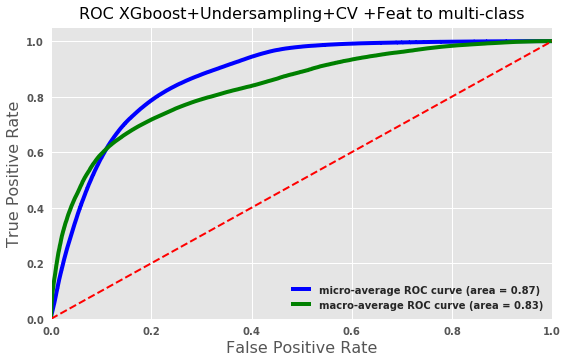

In [150]:
Y_test_df=pd.get_dummies(Y_test,columns=['Cover_Type'])
plot_roc(0,'XGboost+Undersampling+CV +Feat',pred_probab,Y_test_df)

In [151]:
print(classification_report(Y_test.values.ravel(),pred))

             precision    recall  f1-score   support

          0       0.73      0.46      0.56     63552
          1       0.66      0.52      0.58     84991
          2       0.38      0.73      0.50     10726
          3       0.12      0.45      0.20       824
          4       0.01      0.09      0.02      2848
          5       0.16      0.51      0.24      5210
          6       0.50      0.74      0.60      6153

avg / total       0.63      0.51      0.55    174304



In [152]:
print(accuracy_score(Y_test.values.ravel(),pred))

0.5096899669542868


# LGBM

In [90]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary', 
          'num_leaves': 64, 
          'learning_rate': 0.1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 5, 
          'reg_lambda': 10,
          'min_split_gain': 0.5, 
          'min_child_weight': 1, 
          'min_child_samples': 5, 
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

In [91]:
import lightgbm as lgb

In [92]:
lgbm=lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 8,
          silent = True,
          max_depth = params['max_depth'],
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'], 
          scale_pos_weight = params['scale_pos_weight'])

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of LGBM on the Test set:  0.9994382219725431


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.93      0.73      0.82       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



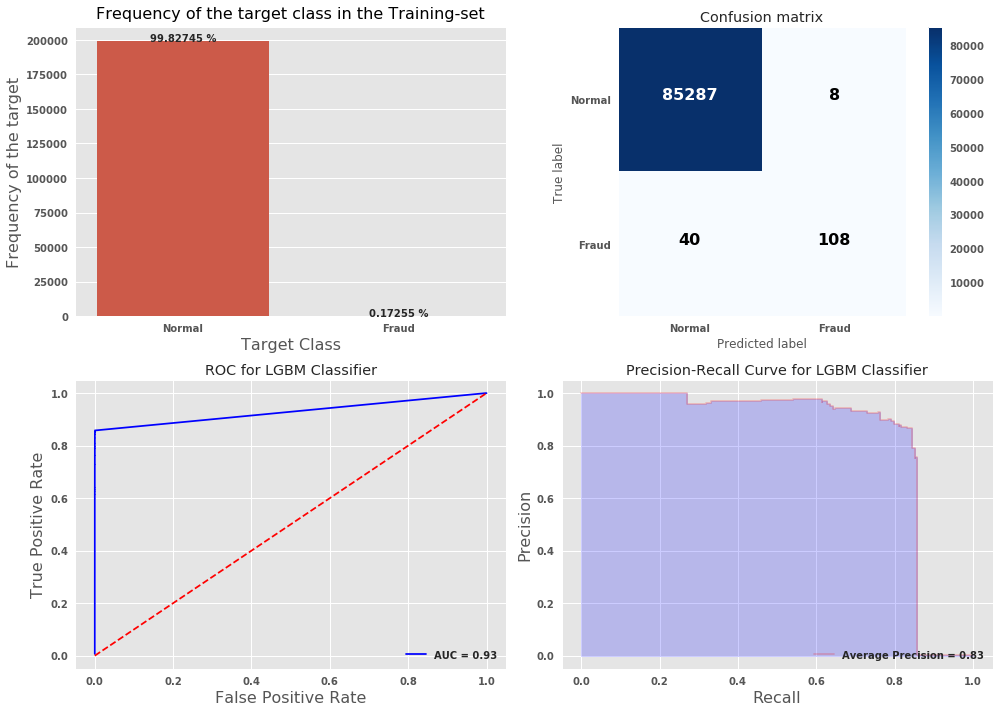

In [93]:
X_train,Y_train,X_test,Y_test=data_prep(data)
lgb_pred,lgb_probab=model_fitting_and_post_processing(lgbm,X_train,Y_train,X_test,Y_test,clf_name='LGBM',class_names=['Normal','Fraud'])

# Neural Networks

In [153]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

#import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.optimizers import SGD,Adam
import keras.backend as K
import keras.callbacks
from keras import regularizers

Using TensorFlow backend.


In [154]:
X_train,Y_train,X_test,Y_test=data_prep(data,feat=True)

In [193]:
X_train.shape

(406708, 63)

In [155]:
X_train_r,X_valid,Y_train_r,Y_valid=train_test_split(X_train,Y_train,test_size=0.1,random_state=0,stratify=Y_train.Cover_Type)

In [181]:
nb_classes=7
l1_num_neuron=500
l2_num_neuron=300
l3_num_neuron=200
l4_num_neuron=100
output_neuron=nb_classes

In [182]:
layer_1 = Dense(l1_num_neuron, activation='relu',kernel_initializer='RandomNormal',kernel_regularizer=regularizers.l2(0.01), input_dim=X_train.shape[1])
layer_2 = Dense(l2_num_neuron, activation='relu',kernel_initializer='RandomNormal',kernel_regularizer=regularizers.l2(0.01))
layer_3 = Dense(l3_num_neuron, activation='relu',kernel_initializer='RandomNormal',kernel_regularizer=regularizers.l2(0.01))
layer_4 = Dense(l4_num_neuron, activation='relu',kernel_initializer='RandomNormal',kernel_regularizer=regularizers.l2(0.01))
layer_out = Dense(output_neuron, activation='softmax',kernel_initializer='RandomNormal',kernel_regularizer=regularizers.l2(0.01))

In [183]:
np.random.seed(0)

In [184]:
mlp=Sequential()
mlp.add(layer_1)
mlp.add(Dropout(0.1))
mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
mlp.add(layer_2)
mlp.add(Dropout(0.3))
mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
mlp.add(layer_3)
mlp.add(Dropout(0.2))
mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
mlp.add(layer_4)
mlp.add(Dropout(0.2))
mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
mlp.add(layer_out)

In [185]:
sgd = SGD(lr=0.01, momentum=0.8, decay=0.1/200, nesterov=True)
mlp.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [186]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 500)               32000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 500)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 500)               2000      
_________________________________________________________________
dense_12 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 300)               1200      
_________________________________________________________________
dense_13 (Dense)             (None, 200)               60200     
__________

In [187]:
from keras.callbacks import EarlyStopping
train_res = mlp.fit(X_train_r.values,
                      Y_train_r.values.ravel(),
                      batch_size=300,
                      epochs=200,
                      verbose=True,
                      validation_data=(X_valid.values,
                                       Y_valid.values.ravel()),
                      callbacks=
                      [EarlyStopping(patience=4,mode='min',
                                     verbose=True)]
                      )

Train on 366037 samples, validate on 40671 samples
Epoch 1/200
366037/366037 [==============================] - 15s 40us/step - loss: 3.4437 - acc: 0.7287 - val_loss: 1.5733 - val_acc: 0.7544
Epoch 2/200
366037/366037 [==============================] - 14s 39us/step - loss: 1.1094 - acc: 0.7783 - val_loss: 0.7927 - val_acc: 0.8077
Epoch 3/200
366037/366037 [==============================] - 14s 39us/step - loss: 0.7123 - acc: 0.8044 - val_loss: 0.5907 - val_acc: 0.8340
Epoch 4/200
366037/366037 [==============================] - 14s 39us/step - loss: 0.5928 - acc: 0.8223 - val_loss: 0.5186 - val_acc: 0.8474
Epoch 5/200
366037/366037 [==============================] - 14s 39us/step - loss: 0.5417 - acc: 0.8342 - val_loss: 0.4728 - val_acc: 0.8629
Epoch 6/200
366037/366037 [==============================] - 14s 39us/step - loss: 0.5116 - acc: 0.8430 - val_loss: 0.4549 - val_acc: 0.8664
Epoch 7/200
366037/366037 [==============================] - 14s 38us/step - loss: 0.4936 - acc: 0.8493

In [188]:
predictions=mlp.predict_classes(X_test.values,verbose=True)

174304/174304 [==============================] - 7s 41us/step


In [189]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test.values.ravel(),predictions)

0.9209427207637232

In [190]:
post_probab_predictions=mlp.predict_proba(X_test,verbose=True)

174304/174304 [==============================] - 7s 39us/step


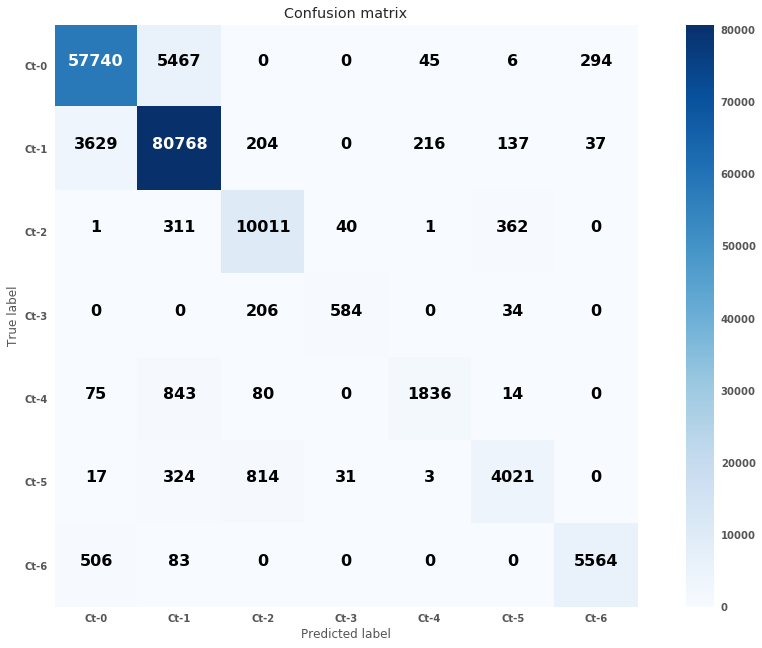

In [191]:
cnf_matrix = confusion_matrix(Y_test.values,predictions)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
class_names = ['Ct-0','Ct-1','Ct-2','Ct-3','Ct-4','Ct-5','Ct-6']
plt.figure(figsize=(15, 10))
plot_confusion_matrix(0,cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.grid('off')
plt.show()

In [192]:
print(classification_report(Y_test.values,predictions))

             precision    recall  f1-score   support

          0       0.93      0.91      0.92     63552
          1       0.92      0.95      0.93     84991
          2       0.88      0.93      0.91     10726
          3       0.89      0.71      0.79       824
          4       0.87      0.64      0.74      2848
          5       0.88      0.77      0.82      5210
          6       0.94      0.90      0.92      6153

avg / total       0.92      0.92      0.92    174304



In [99]:
def plot_prc(axd,clf_name,pred_probab,Y_test_df):
    plt.sca(axd)
    

    recall= dict()
    precision = dict()
    prc = dict()
    for i in range(7):
        recall[i], precision[i], _ = precision_recall_curve(Y_test_df.iloc[:, i], pred_probab[:, i])
        prc[i] = average_precision_score(recall[i], precision[i])

    prc_dict={}
    for j in range(len(prc)):
        prc_dict[str('recall')+str(j)]=recall[j]
        prc_dict[str('precision')+str(j)]=precision[j]

    # Compute micro-average PRC curve and PRC area
    recall["micro"], precision["micro"], _ = precision_recall_curve(Y_test_df.values.ravel(), pred_probab.ravel())
    prc["micro"] = average_precision_score(recall["micro"], precision["micro"])

    from itertools import cycle
    all_fpr = np.unique(np.concatenate([recall[i] for i in range(7)]))
    lw=2
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(7):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= 7

    recall["macro"] = all_fpr
    precision["macro"] = mean_tpr
    prc["macro"] = average_precision_score(recall["macro"], precision["macro"])

    # Plot all ROC curves
    #plt.figure()
    plt.plot(recall["micro"], precision["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(prc["micro"]),
             color='blue', linewidth=4)

    plt.plot(recall["macro"], precision["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='green', linewidth=4)

    #plt.plot([0, 1], [0, 1], 'r--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall',**axis_font)
    plt.ylabel('Precision',**axis_font)
    titled='Precision-Recall curve'+clf_name + ' to multi-class'
    plt.title(titled,**title_font)
    plt.legend(loc="lower right")